In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
image_folder_path='/content/drive/MyDrive/kaggle/archive (9)/Images'
caption_file_path='/content/drive/MyDrive/kaggle/archive (9)/captions.txt'

In [ ]:
df = pd.read_csv(caption_file_path)
df.head(10)

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...
7,1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots a...
8,1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each o...
9,1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .


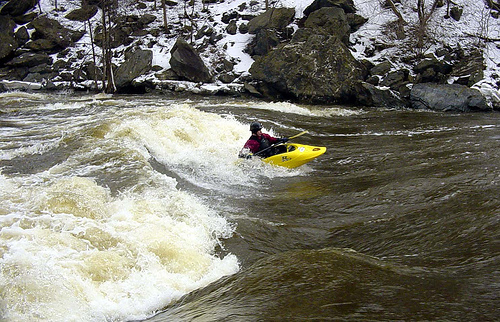

In [ ]:
import random
data_idx = random.randint(0,(len(df)-1))
image_path = image_folder_path + "/" + df.iloc[data_idx,0]
image = Image.open(image_path)
from IPython.display import display
display(image)

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter

class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {v: k for k, v in self.itos.items()}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenize(text):
        return word_tokenize(text.lower())

    def build_vocab(self, sentence_list):
        frequencies = Counter()
        idx = 4
        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenize(text)
        return [self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized_text]


In [ ]:
 nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
v = Vocabulary(freq_threshold=1)
v.build_vocab(["This is a new city"])
print(v.stoi)
print(v.numericalize("This is a new city"))

{'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'this': 4, 'is': 5, 'a': 6, 'new': 7, 'city': 8}
[4, 5, 6, 7, 8]


In [ ]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self,root_dir,captions_file,transform=None, freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocab(self.captions.tolist())

    def __len__(self):
        return len(self.df)

    def __getitem__(self,idx):
        caption = self.captions[idx]
        img_name = self.imgs[idx]

        img_location = os.path.join(self.root_dir,img_name)
        img = Image.open(img_location).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        caption_vec = []
        caption_vec += [self.vocab.stoi["<SOS>"]]
        caption_vec += self.vocab.numericalize(caption)
        caption_vec += [self.vocab.stoi["<EOS>"]]

        return img, torch.tensor(caption_vec)

In [ ]:
import torchvision.transforms as T
transforms = T.Compose([
    T.Resize((224,224)),
    T.ToTensor()
])

In [ ]:
dataset = CustomDataset(
        root_dir = image_folder_path,
        captions_file = caption_file_path,
        transform = transforms
)

In [ ]:
from torch.nn.utils.rnn import pad_sequence
class CapsCollate:
    def __init__(self,pad_idx,batch_first=False):
        self.pad_idx = pad_idx
        self.batch_first = batch_first

    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs,dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.pad_idx)
        return imgs,targets

In [ ]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKER = 1

pad_idx = dataset.vocab.stoi["<PAD>"]

data_loader = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    collate_fn=CapsCollate(pad_idx=pad_idx,batch_first=True)
)

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim

In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self,embed_size):
        super(EncoderCNN,self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)

        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features,embed_size)

    def forward(self,images):
        features = self.resnet(images)
        features = features.view(features.size(0),-1)
        features = self.embed(features)
        return features

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self,embed_size,hidden_size,vocab_size,num_layers=1,drop_prob=0.3):
        super(DecoderRNN,self).__init__()
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.lstm = nn.LSTM(embed_size,hidden_size,num_layers=num_layers,batch_first=True)
        self.fcn = nn.Linear(hidden_size,vocab_size)
        self.drop = nn.Dropout(drop_prob)

    def forward(self,features, captions):
        embeds = self.embedding(captions[:,:-1])
        x = torch.cat((features.unsqueeze(1),embeds),dim=1)
        x,_ = self.lstm(x)
        x = self.fcn(x)
        return x
    def generate_caption(self,inputs,hidden=None,max_len=20,vocab=None):

        batch_size = inputs.size(0)

        captions = []

        for i in range(max_len):
            output,hidden = self.lstm(inputs,hidden)
            output = self.fcn(output)
            output = output.view(batch_size,-1)
            predicted_word_idx = output.argmax(dim=1)
            captions.append(predicted_word_idx.item())
            if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break
            inputs = self.embedding(predicted_word_idx.unsqueeze(0))
        return [vocab.itos[idx] for idx in captions]

In [ ]:
class EncoderDecoder(nn.Module):
    def __init__(self,embed_size,hidden_size,vocab_size,num_layers=1,drop_prob=0.3):
        super(EncoderDecoder,self).__init__()
        self.encoder = EncoderCNN(embed_size)
        self.decoder = DecoderRNN(embed_size,hidden_size,vocab_size,num_layers,drop_prob)

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

In [ ]:
device="cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
embed_size = 400
hidden_size = 512
vocab_size = len(dataset.vocab)
num_layers = 2
learning_rate = 0.0001

In [ ]:
model = EncoderDecoder(embed_size, hidden_size, vocab_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
from tqdm import tqdm

num_epochs = 10
for epoch in range(1, num_epochs + 1):
    data_loader = tqdm(data_loader, total=len(data_loader), desc=f"Epoch {epoch}/{num_epochs}")

    for idx, (image, captions) in enumerate(data_loader):
        model.train()
        image, captions = image.to(device), captions.to(device)
        optimizer.zero_grad()
        outputs = model(image, captions)
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))
        loss.backward()
        optimizer.step()
        data_loader.set_postfix({"Loss": loss.item()}, refresh=True)





Epoch 10/10: 100%|██████████| 1265/1265 [05:45<00:00,  3.66it/s, Loss=2.15]


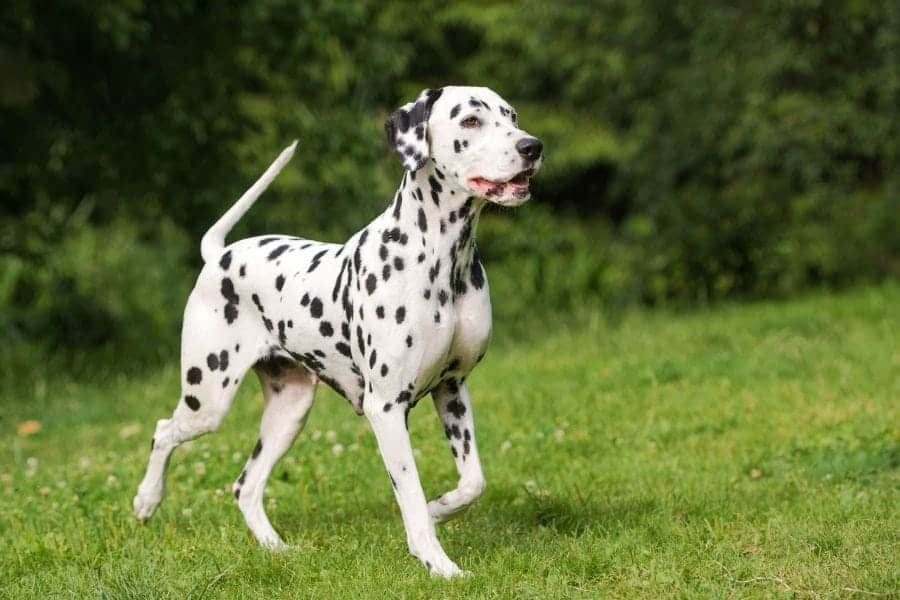

a white dog with a red collar is running through a field of grass .


In [ ]:

test_image_path = '/content/black-and-white-dog-names-new-4.jpg'
test_image = Image.open(test_image_path)
display(test_image)
test_image_tensor = transforms(test_image).unsqueeze(0)

test_image_tensor = test_image_tensor.to(device)

model.eval()

with torch.no_grad():
    features = model.encoder(test_image_tensor.to(device))

captions = model.decoder.generate_caption(features.unsqueeze(0),  vocab=dataset.vocab)

caption = ' '.join(captions)
caption = caption.replace('<SOS>', '').replace('<EOS>', '').strip()
print(caption)
